  Subject       Process  Accuracy (%)
0     S01  Conventional           100
1     S02  Conventional            70
2     S03  Conventional            86
3     S04  Conventional            97
4     S01      Proposed            98
5     S02      Proposed            80
6     S03      Proposed            96
7     S04      Proposed            97


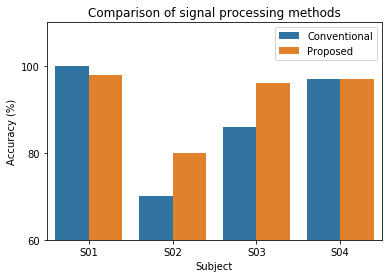

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

raw_data = {'Subject' : ['S01', 'S02', 'S03', 'S04', 'S01', 'S02', 'S03', 'S04'], 
                'Process' : ['Conventional', 'Conventional', 'Conventional', 'Conventional', 'Proposed', 'Proposed', 'Proposed', 'Proposed'],
            'Accuracy (%)' : [100, 70, 86, 97, 98, 80, 96, 97]}

df = pd.DataFrame(raw_data)
print(df)

sns.barplot(data=df, x='Subject', y='Accuracy (%)', hue='Process')
plt.title('Comparison of signal processing methods')
plt.ylim(60, 110)
plt.yticks([60, 80, 100])
plt.legend(loc='best')
plt.show()



In [5]:
u = np.mean([100, 70, 86, 97])
print(u)

u2 = np.mean([98, 80, 96, 97])
print(u2)

std1 = np.std([100, 70, 86, 97])
print(std1)

std2 = np.std([98, 80, 96, 97])
print(std2)

88.25
92.75
11.755317945508747
7.39509972887452


In [11]:
import numpy as np
from scipy.stats import wilcoxon

conventional = np.array([100, 70, 86, 97])
proposed = np.array([98, 80, 96, 97])

differ =  proposed - conventional
print(differ)

w, p = wilcoxon(differ)
w, p

[-2 10 10  0]


(1.0, 0.27630291733748347)

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
import shutil
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.externals import joblib

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    

def Make_Average_Component(Epochs, AverSize):
    Num = int(np.floor(Epochs.shape[0]/AverSize))
    
    Epochs_Aver = np.zeros((Num, Epochs.shape[1], Epochs.shape[2]))
    for i in range(Num):
        Epochs_Aver[i, :, :] = np.mean(Epochs[AverSize*i:AverSize*i+AverSize, :, :], axis=0)
    
    return Epochs_Aver
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
        
        Epochs = Standardization(Epochs)
        
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver

def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features
    
def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch

def Standardization(eegData):
    eegData = eegData.T
    mean_on_data = eegData.mean(axis=0)
    std_on_data = eegData.std(axis=0)

    eegData_standardized = (eegData - mean_on_data) / std_on_data
    eegData_standardized = eegData_standardized.T
    return eegData_standardized
    
def MinMax(eegData):
    eegData = eegData.T
    mins = np.min(eegData, axis = 0)
    maxs = np.max(eegData, axis = 0)

    eegData_normalized = (eegData - mins)/(maxs - mins)
    eegData_normalized = eegData_normalized.T
    
    return eegData_normalized 
    
def main():
        Classifier_path = 'C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\Zero\\ZeroModel\\'
        classifier_list = sorted(glob.glob(Classifier_path + '*.h5'), key=os.path.getmtime, reverse=True)
        weight_list = sorted(glob.glob(Classifier_path + 'weight\\*.h5'), key=os.path.getmtime, reverse=True)
        print("classifer:", classifier_list[0])
        model = load_model(classifier_list[0])
        model.load_weights(weight_list[0]) 
        
        root_path = 'C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\EEGData\\VR300\\0729\\sion\\'
        resampleRate = 100
        
        mat_path = root_path + 'Online\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime, reverse=True)
        score = 0
        wrong_ans = []
        
        for mat_file in current_list:
            print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData_ = np.transpose(eegData)
            eegData = eegData_[:channelNum]
            buttonNum = 7
            
            eegData = Standardization(eegData)
            eegData = MinMax(eegData)
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, 0.1, 30, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor(1.0 * samplingFreq))
            offset = int(np.floor(0.0 * samplingFreq))
            baseline = int(np.floor(1.0 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))
            
            for i in range(buttonNum):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
            
            # PCA
            componentNum = 3
            pca_all = np.zeros((buttonNum, componentNum, 100))
            pca = PCA(n_components=componentNum) # 주성분을 몇개로 할지 결정
            for i in range(buttonNum):
                pca_all[i] = pca.fit_transform(Epochs_final[i].transpose()).transpose()
            
            #correlate to pick Principal Component
            mat = np.loadtxt('C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\Zero\\Template\\template.out')
#             temp_t = mat[0]
#             temp_t_new = mat[1]
            
#             mat[0] = temp_t

            for i in range(buttonNum):
                for j in range(componentNum):
                    mat[1] = pca_all[i,j,:]
                    corrcoef = np.corrcoef(mat)
                    coef = corrcoef[0,1]
                    
                    if coef < 0:
                        pca_all[i,j,:] = -pca_all[i,j,:]
                    
            test = np.reshape(pca_all, (buttonNum, 1, componentNum, resampleRate))
            
            #SCORING
            Answers = model.predict(test)
            answer = np.argmax(Answers[:, 1]) + 1
            
            if int(ans) == int(answer): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', answer)
            
        print('wrong answer', wrong_ans)
        print('score:', score, "Accuracy: ", score/len(current_list))
        
if __name__ == "__main__":
    main()